## Data Preparation

In [1]:
import h5py
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
from itertools import chain
from collections import Counter
import pickle
import cv2

The aim of this notebook is to generate data for our data generator. Here, images will be processed on a VGG16 model in order to generate a feature vector. Captions are loaded and stored in a convinient way to be loaded for generator. 

For dataset we are using MS COCO dataset for Image Captioning. The dataset has its own API to load its data. Here I load both train and validation dataset.

In [2]:
annFile_train = "annotations/captions_train2014.json"
annFile_val = "annotations/captions_val2014.json"

coco_train = COCO(annFile_train)
coco_val = COCO(annFile_val)

loading annotations into memory...
Done (t=1.95s)
creating index...
index created!
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


In [3]:
imgIds_train = coco_train.getImgIds()
imgIds_val = coco_val.getImgIds()

annIds_train = coco_train.getAnnIds(imgIds_train)
annIds_val = coco_val.getAnnIds(imgIds_val)
anns_train = coco_train.loadAnns(annIds_train)
anns_val = coco_val.loadAnns(annIds_val)

imgs_train = coco_train.loadImgs(imgIds_train)
imgs_val = coco_val.loadImgs(imgIds_val)

I am only interested in captions and image name here, so remove all other annotation columns.

In [11]:
imgs_train_df = pd.DataFrame(imgs_train)
imgs_val_df = pd.DataFrame(imgs_val)

anns_train_df = pd.DataFrame(anns_train)
anns_val_df = pd.DataFrame(anns_val)

In [12]:
img_train_new = imgs_train_df.drop(['coco_url','date_captured','flickr_url','height','width','license'], axis=1)
img_val_new = imgs_val_df.drop(['coco_url','date_captured','flickr_url','height','width','license'], axis=1)

img_train_new.rename(columns={'id': 'image_id'}, inplace=True)
img_val_new.rename(columns={'id': 'image_id'}, inplace=True)

anns_train_df['caption'] = anns_train_df['caption'].apply(lambda x: '<start> ' + x + ' <end>')
anns_val_df['caption'] = anns_val_df['caption'].apply(lambda x: '<start> ' + x + ' <end>')

train_df = pd.merge(anns_train_df, img_train_new, on='image_id', how='left')
val_df = pd.merge(anns_val_df, img_val_new, on='image_id', how='left')

In [13]:
train_df.drop(['id'], axis=1, inplace=True)
val_df.drop(['id'], axis=1, inplace=True)

In [14]:
train_df.head()

,caption,image_id,file_name
0,<start> People shopping in an open market for ...,262145,COCO_train2014_000000262145.jpg
1,<start> An open market full of people and pile...,262145,COCO_train2014_000000262145.jpg
2,<start> People are shopping at an open air pro...,262145,COCO_train2014_000000262145.jpg
3,<start> Large piles of carrots and potatoes at...,262145,COCO_train2014_000000262145.jpg
4,<start> People shop for vegetables like carrot...,262145,COCO_train2014_000000262145.jpg


The dataframe is stored into CSVs here. Both image name and captions are stored.

In [15]:
train_df.to_csv('data/training.csv', index=False)
val_df.to_csv('data/validation.csv', index=False)

Making vocabulary

In order to process captions, a vocabulary must be built with all unique words from captions. Those unique words form a list of index and a list of words to encode and decode the input and output respectively.

In [9]:
captions = train_df['caption']
words = [txt.split() for txt in captions]
vocab = []
for word in words:
    vocab.extend(word)
vocab = list(set(vocab))
vocab_size = len(vocab)
print vocab_size

54028


In [10]:
word_index = {}
index_word = {}
for i, word in enumerate(vocab):
    word_index[word]=i
    index_word[i]=word

Saving lists into files via pickle

In [11]:
pickle.dump(word_index, open('word_index.p', 'wb'))
pickle.dump(index_word, open('index_word.p', 'wb'))

Image Features

In order to analyze images, a preprocess on images was made to extract some features. The model needs two models, one for images and another for captions. To improve performance on final model, the convolution part of image model is executed here and all the image features retrieved are saved to be processed later by the final model.

Here, I use VGG16 to process image and get a list of probabilities of predicted classes. Those lists are saved for the generator and used by final model.

Now the images are loaded to the memory

In [8]:
from keras.preprocessing import image

Using TensorFlow backend.


In [9]:
train_imgs = set(train_df['file_name'])
img_dir = "images/"
images = []
for img_file in train_imgs:
    img = image.load_img(img_dir + img_file, target_size=(224, 224))
    for i in range(0,5):
        images.append(img)

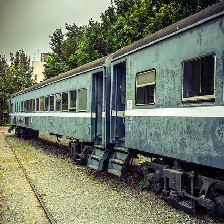

In [14]:
images[11]

Now the VGG16 net will predict classes for each image on list and save the list of probabilities.

In [11]:
from keras.applications.vgg16 import VGG16

from imagenet_utils import preprocess_input

In [12]:
model = VGG16(weights='imagenet', include_top=True, input_shape = (224, 224, 3))

c = 0
img_features = []
for img in images:
    c += 1
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = np.asarray(img)
    img_feature = model.predict(img)
    #img_feature = np.asarray(img_feature)
    #img_feature = img_feature.argmax(axis=-1)
    if c % 100 == 0:
        print "Processed {0} images".format(c)
    img_features.append(img_feature[0])
img_features = np.asarray(img_features)

Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3100 images
Processed 3200 images
Processed 3300 images
Processed 3400 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4100 images
Processed 4200 images
Processed 4300 images
Processed 4400 images
Processed 4500 images
Processed 4600 imag

Processed 36200 images
Processed 36300 images
Processed 36400 images
Processed 36500 images
Processed 36600 images
Processed 36700 images
Processed 36800 images
Processed 36900 images
Processed 37000 images
Processed 37100 images
Processed 37200 images
Processed 37300 images
Processed 37400 images
Processed 37500 images
Processed 37600 images
Processed 37700 images
Processed 37800 images
Processed 37900 images
Processed 38000 images
Processed 38100 images
Processed 38200 images
Processed 38300 images
Processed 38400 images
Processed 38500 images
Processed 38600 images
Processed 38700 images
Processed 38800 images
Processed 38900 images
Processed 39000 images
Processed 39100 images
Processed 39200 images
Processed 39300 images
Processed 39400 images
Processed 39500 images
Processed 39600 images
Processed 39700 images
Processed 39800 images
Processed 39900 images
Processed 40000 images
Processed 40100 images
Processed 40200 images
Processed 40300 images
Processed 40400 images
Processed 4

Processed 71900 images
Processed 72000 images
Processed 72100 images
Processed 72200 images
Processed 72300 images
Processed 72400 images
Processed 72500 images
Processed 72600 images
Processed 72700 images
Processed 72800 images
Processed 72900 images
Processed 73000 images
Processed 73100 images
Processed 73200 images
Processed 73300 images
Processed 73400 images
Processed 73500 images
Processed 73600 images
Processed 73700 images
Processed 73800 images
Processed 73900 images
Processed 74000 images
Processed 74100 images
Processed 74200 images
Processed 74300 images
Processed 74400 images
Processed 74500 images
Processed 74600 images
Processed 74700 images
Processed 74800 images
Processed 74900 images
Processed 75000 images
Processed 75100 images
Processed 75200 images
Processed 75300 images
Processed 75400 images
Processed 75500 images
Processed 75600 images
Processed 75700 images
Processed 75800 images
Processed 75900 images
Processed 76000 images
Processed 76100 images
Processed 7

Processed 107300 images
Processed 107400 images
Processed 107500 images
Processed 107600 images
Processed 107700 images
Processed 107800 images
Processed 107900 images
Processed 108000 images
Processed 108100 images
Processed 108200 images
Processed 108300 images
Processed 108400 images
Processed 108500 images
Processed 108600 images
Processed 108700 images
Processed 108800 images
Processed 108900 images
Processed 109000 images
Processed 109100 images
Processed 109200 images
Processed 109300 images
Processed 109400 images
Processed 109500 images
Processed 109600 images
Processed 109700 images
Processed 109800 images
Processed 109900 images
Processed 110000 images
Processed 110100 images
Processed 110200 images
Processed 110300 images
Processed 110400 images
Processed 110500 images
Processed 110600 images
Processed 110700 images
Processed 110800 images
Processed 110900 images
Processed 111000 images
Processed 111100 images
Processed 111200 images
Processed 111300 images
Processed 111400

Processed 141500 images
Processed 141600 images
Processed 141700 images
Processed 141800 images
Processed 141900 images
Processed 142000 images
Processed 142100 images
Processed 142200 images
Processed 142300 images
Processed 142400 images
Processed 142500 images
Processed 142600 images
Processed 142700 images
Processed 142800 images
Processed 142900 images
Processed 143000 images
Processed 143100 images
Processed 143200 images
Processed 143300 images
Processed 143400 images
Processed 143500 images
Processed 143600 images
Processed 143700 images
Processed 143800 images
Processed 143900 images
Processed 144000 images
Processed 144100 images
Processed 144200 images
Processed 144300 images
Processed 144400 images
Processed 144500 images
Processed 144600 images
Processed 144700 images
Processed 144800 images
Processed 144900 images
Processed 145000 images
Processed 145100 images
Processed 145200 images
Processed 145300 images
Processed 145400 images
Processed 145500 images
Processed 145600

Processed 175700 images
Processed 175800 images
Processed 175900 images
Processed 176000 images
Processed 176100 images
Processed 176200 images
Processed 176300 images
Processed 176400 images
Processed 176500 images
Processed 176600 images
Processed 176700 images
Processed 176800 images
Processed 176900 images
Processed 177000 images
Processed 177100 images
Processed 177200 images
Processed 177300 images
Processed 177400 images
Processed 177500 images
Processed 177600 images
Processed 177700 images
Processed 177800 images
Processed 177900 images
Processed 178000 images
Processed 178100 images
Processed 178200 images
Processed 178300 images
Processed 178400 images
Processed 178500 images
Processed 178600 images
Processed 178700 images
Processed 178800 images
Processed 178900 images
Processed 179000 images
Processed 179100 images
Processed 179200 images
Processed 179300 images
Processed 179400 images
Processed 179500 images
Processed 179600 images
Processed 179700 images
Processed 179800

Processed 209900 images
Processed 210000 images
Processed 210100 images
Processed 210200 images
Processed 210300 images
Processed 210400 images
Processed 210500 images
Processed 210600 images
Processed 210700 images
Processed 210800 images
Processed 210900 images
Processed 211000 images
Processed 211100 images
Processed 211200 images
Processed 211300 images
Processed 211400 images
Processed 211500 images
Processed 211600 images
Processed 211700 images
Processed 211800 images
Processed 211900 images
Processed 212000 images
Processed 212100 images
Processed 212200 images
Processed 212300 images
Processed 212400 images
Processed 212500 images
Processed 212600 images
Processed 212700 images
Processed 212800 images
Processed 212900 images
Processed 213000 images
Processed 213100 images
Processed 213200 images
Processed 213300 images
Processed 213400 images
Processed 213500 images
Processed 213600 images
Processed 213700 images
Processed 213800 images
Processed 213900 images
Processed 214000

Processed 244100 images
Processed 244200 images
Processed 244300 images
Processed 244400 images
Processed 244500 images
Processed 244600 images
Processed 244700 images
Processed 244800 images
Processed 244900 images
Processed 245000 images
Processed 245100 images
Processed 245200 images
Processed 245300 images
Processed 245400 images
Processed 245500 images
Processed 245600 images
Processed 245700 images
Processed 245800 images
Processed 245900 images
Processed 246000 images
Processed 246100 images
Processed 246200 images
Processed 246300 images
Processed 246400 images
Processed 246500 images
Processed 246600 images
Processed 246700 images
Processed 246800 images
Processed 246900 images
Processed 247000 images
Processed 247100 images
Processed 247200 images
Processed 247300 images
Processed 247400 images
Processed 247500 images
Processed 247600 images
Processed 247700 images
Processed 247800 images
Processed 247900 images
Processed 248000 images
Processed 248100 images
Processed 248200

Processed 278300 images
Processed 278400 images
Processed 278500 images
Processed 278600 images
Processed 278700 images
Processed 278800 images
Processed 278900 images
Processed 279000 images
Processed 279100 images
Processed 279200 images
Processed 279300 images
Processed 279400 images
Processed 279500 images
Processed 279600 images
Processed 279700 images
Processed 279800 images
Processed 279900 images
Processed 280000 images
Processed 280100 images
Processed 280200 images
Processed 280300 images
Processed 280400 images
Processed 280500 images
Processed 280600 images
Processed 280700 images
Processed 280800 images
Processed 280900 images
Processed 281000 images
Processed 281100 images
Processed 281200 images
Processed 281300 images
Processed 281400 images
Processed 281500 images
Processed 281600 images
Processed 281700 images
Processed 281800 images
Processed 281900 images
Processed 282000 images
Processed 282100 images
Processed 282200 images
Processed 282300 images
Processed 282400

Processed 312500 images
Processed 312600 images
Processed 312700 images
Processed 312800 images
Processed 312900 images
Processed 313000 images
Processed 313100 images
Processed 313200 images
Processed 313300 images
Processed 313400 images
Processed 313500 images
Processed 313600 images
Processed 313700 images
Processed 313800 images
Processed 313900 images
Processed 314000 images
Processed 314100 images
Processed 314200 images
Processed 314300 images
Processed 314400 images
Processed 314500 images
Processed 314600 images
Processed 314700 images
Processed 314800 images
Processed 314900 images
Processed 315000 images
Processed 315100 images
Processed 315200 images
Processed 315300 images
Processed 315400 images
Processed 315500 images
Processed 315600 images
Processed 315700 images
Processed 315800 images
Processed 315900 images
Processed 316000 images
Processed 316100 images
Processed 316200 images
Processed 316300 images
Processed 316400 images
Processed 316500 images
Processed 316600

Processed 346700 images
Processed 346800 images
Processed 346900 images
Processed 347000 images
Processed 347100 images
Processed 347200 images
Processed 347300 images
Processed 347400 images
Processed 347500 images
Processed 347600 images
Processed 347700 images
Processed 347800 images
Processed 347900 images
Processed 348000 images
Processed 348100 images
Processed 348200 images
Processed 348300 images
Processed 348400 images
Processed 348500 images
Processed 348600 images
Processed 348700 images
Processed 348800 images
Processed 348900 images
Processed 349000 images
Processed 349100 images
Processed 349200 images
Processed 349300 images
Processed 349400 images
Processed 349500 images
Processed 349600 images
Processed 349700 images
Processed 349800 images
Processed 349900 images
Processed 350000 images
Processed 350100 images
Processed 350200 images
Processed 350300 images
Processed 350400 images
Processed 350500 images
Processed 350600 images
Processed 350700 images
Processed 350800

Processed 380900 images
Processed 381000 images
Processed 381100 images
Processed 381200 images
Processed 381300 images
Processed 381400 images
Processed 381500 images
Processed 381600 images
Processed 381700 images
Processed 381800 images
Processed 381900 images
Processed 382000 images
Processed 382100 images
Processed 382200 images
Processed 382300 images
Processed 382400 images
Processed 382500 images
Processed 382600 images
Processed 382700 images
Processed 382800 images
Processed 382900 images
Processed 383000 images
Processed 383100 images
Processed 383200 images
Processed 383300 images
Processed 383400 images
Processed 383500 images
Processed 383600 images
Processed 383700 images
Processed 383800 images
Processed 383900 images
Processed 384000 images
Processed 384100 images
Processed 384200 images
Processed 384300 images
Processed 384400 images
Processed 384500 images
Processed 384600 images
Processed 384700 images
Processed 384800 images
Processed 384900 images
Processed 385000

(99, 1000)

AttributeError: 'list' object has no attribute 'shape'

In [13]:
pickle.dump(img_features, open('image_features.p', 'wb'))